# Quantum Algorithms

In [60]:
from openql import openql as ql
from utils import simulate, plot_histogram, random_state


In [61]:
ql.initialize()
compiler = ql.Compiler("compiler", "./compiler-config.json")

platform = ql.Platform("platform", "none")
platform.set_compiler(compiler=compiler)


## Bernstein-Vazirani Algorithm

In [62]:
N = 5  # length of the secret message
secret = random_state(N)  # generate secret message

secret


'11000'

In [63]:
bv_program = ql.Program("bernstein-vazirani", platform=platform, qubit_count=N + 1)
bv_kernel = ql.Kernel("bv-kernel", platform=platform, qubit_count=N + 1)

# apply Hadamard gate to first N qubits
for qubit in range(N):
    bv_kernel.hadamard(qubit)

# apply X gate and Hadamard gate to the last qubit
bv_kernel.x(N)
bv_kernel.hadamard(N)

# oracle
for i, qubit in enumerate(secret):
    if qubit == "1":
        bv_kernel.cnot(i, N)

# reverse Hadamards and measure
for qubit in range(N):
    bv_kernel.hadamard(qubit)
    bv_kernel.measure(qubit)

bv_program.add_kernel(bv_kernel)
bv_program.compile()


In [64]:
counts = simulate(program=bv_program, measured=range(N), shots=1)


In [65]:
print(f"{counts=}")
print(f"{secret=}")


counts={'11000': 1}
secret='11000'


## Teleportation Algorithm

In [66]:
tp_program = ql.Program("teleportation", platform=platform, qubit_count=3)
tp_kernel = ql.Kernel("tp-kernel", platform=platform, qubit_count=3)

# prepare state that will be sent, ie |+>
tp_kernel.hadamard(0)

# create bell state for Alice and Bob
tp_kernel.hadamard(1)
tp_kernel.cnot(1, 2)

# expansion in Bell's basis by Alice
tp_kernel.cnot(0, 1)
tp_kernel.hadamard(0)

# Bob's state translation
tp_kernel.cnot(1, 2)
tp_kernel.cz(0, 2)

# make measurements
tp_kernel.measure(0)
tp_kernel.measure(1)
tp_kernel.measure(2)

tp_program.add_kernel(tp_kernel)
tp_program.compile()


In [67]:
counts = simulate(program=tp_program, measured=[2], shots=1024)


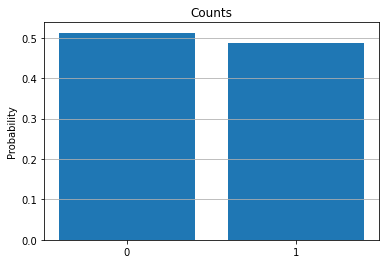

In [68]:
plot_histogram(counts)


## Grover's Algorithm

### Single-solution oracle

In [69]:
# choose random state as a winner
winner = random_state(2)
winner

'11'

In [70]:
# initialize program and kernel
grs_program = ql.Program("grovers-single", platform=platform, qubit_count=2)
grs_kernel = ql.Kernel("grs-kernel", platform=platform, qubit_count=2)

# apply Hadamard to all qubits
# start with equally distributed probabilities
grs_kernel.hadamard(0)
grs_kernel.hadamard(1)

# oracle based on random winner
grs_kernel.cz(0, 1)
for i, qubit in enumerate(winner):
    if qubit == "0":
        grs_kernel.x(i)
        
# amplification
grs_kernel.hadamard(0)
grs_kernel.hadamard(1)
grs_kernel.z(0)
grs_kernel.z(1)
grs_kernel.cz(0, 1)
grs_kernel.hadamard(0)
grs_kernel.hadamard(1)

# measurements
grs_kernel.measure(0)
grs_kernel.measure(1)

grs_program.add_kernel(grs_kernel)
grs_program.compile()

In [71]:
counts = simulate(program=grs_program, shots=1)

In [72]:
counts


{'11': 1}

### Double-solution oracle

In [73]:
# choose two random winners
winner1 = "100"
winner2 = "111"

In [74]:
grd_program = ql.Program("grovers-double", platform=platform, qubit_count=3)
grd_kernel = ql.Kernel("grd-kernel", platform=platform, qubit_count=3)

for qubit in range(3):
    grd_kernel.hadamard(qubit)

# oracle for winners: 100 and 111
grd_kernel.z(0)
grd_kernel.cz(0, 1)
grd_kernel.cz(0, 2)

# amplification
for qubit in range(3):
    grd_kernel.hadamard(qubit)
    grd_kernel.x(qubit)

grd_kernel.hadamard(0)
grd_kernel.toffoli(2, 1, 0)
grd_kernel.hadamard(0)

for qubit in range(3):
    grd_kernel.x(qubit)
    grd_kernel.hadamard(qubit)

# measurements
for qubit in range(3):
    grd_kernel.measure(qubit)

grd_program.add_kernel(grd_kernel)
grd_program.compile()

In [75]:
counts = simulate(program=grd_program, shots=1024)

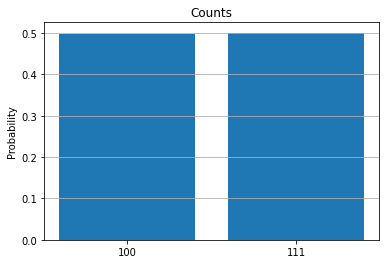

In [76]:
plot_histogram(counts)